In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        (os.path.join(dirname, filename))
print('done')
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

done


In [2]:
!pip install -q pytorch-msssim
print('Done')

Done


In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pytorch_msssim import ssim
import torch.nn.functional as F
from tqdm import tqdm
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch
import cv2
import torch
import torch.nn as nn
from torchvision.transforms import ToTensor, Compose
from glob import glob
from math import log10
import pytorch_msssim


In [4]:
train_images = "/kaggle/input/dlp-jan-2025-nppe-3/archive/train/train"
train_gt = "/kaggle/input/dlp-jan-2025-nppe-3/archive/train/gt"
val_images = "/kaggle/input/dlp-jan-2025-nppe-3/archive/val/val"
val_gt = "/kaggle/input/dlp-jan-2025-nppe-3/archive/val/gt"
test_images = "/kaggle/input/dlp-jan-2025-nppe-3/archive/test"

In [5]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_images_in_range(first_directory, second_directory, start_index, end_index):
    """
    Displays images from two directories in a given index range.

    Args:
        first_directory (str): Path to the first directory containing images.
        second_directory (str): Path to the second directory containing images.
        start_index (int): Starting index (inclusive).
        end_index (int): Ending index (exclusive).
    """
    # List and sort files in each directory
    first_dir_files = sorted(os.listdir(first_directory))
    second_dir_files = sorted(os.listdir(second_directory))
    
    # Select images in the given range
    first_directory_images = [os.path.join(first_directory, file) for file in first_dir_files[start_index:end_index]]
    second_directory_images = [os.path.join(second_directory, file) for file in second_dir_files[start_index:end_index]]
    
    num_images = len(first_directory_images) + len(second_directory_images)
    
    # Plot images
    plt.figure(figsize=(15, 5))
    
    # Plot images from the first directory
    for i, img_path in enumerate(first_directory_images):
        img = mpimg.imread(img_path)
        plt.subplot(2, end_index - start_index, i + 1)
        plt.imshow(img)
        plt.title(f"Image {start_index + i}")
        plt.axis('off')
    
    # Plot images from the second directory
    for i, img_path in enumerate(second_directory_images):
        img = mpimg.imread(img_path)
        plt.subplot(2, end_index - start_index, len(first_directory_images) + i + 1)
        plt.imshow(img)
        plt.title(f"Ground Truth {start_index + i}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

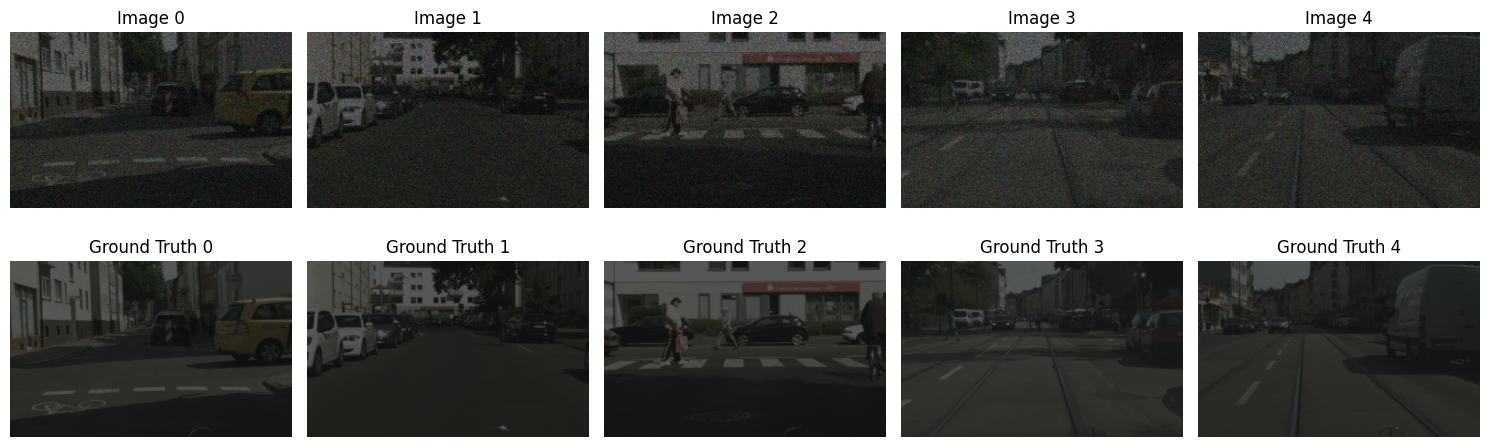

In [6]:
# Call the function with desired index range

display_images_in_range(val_images, val_gt, start_index=0, end_index=5)

In [7]:
!pip install -q basicsr
print("Done")

Done


In [8]:
!pip install -q pytorch-msssim


In [9]:
def combined_loss(output, target):
    l1 = criterion(output, target)
    ssim_loss = 1 - ssim(output, target, data_range=1.0, size_average=True)
    return l1 + 0.5 * ssim_loss  # Weighted sum (adjustable)


In [10]:
def calculate_psnr(output, target):
    mse = F.mse_loss(output, target)
    if mse == 0:
        return 100
    return 20 * log10(1.0 / torch.sqrt(mse))


In [ ]:

class LowLightDataset(Dataset):
    def __init__(self, input_dir, gt_dir, transform=None):
        self.input_files = sorted(glob(os.path.join(input_dir, "*")))
        self.gt_files = sorted(glob(os.path.join(gt_dir, "*")))
        self.transform = transform

    def __len__(self):
        return len(self.input_files)

    def __getitem__(self, idx):
        input_img = Image.open(self.input_files[idx]).convert("RGB")
        gt_img = Image.open(self.gt_files[idx]).convert("RGB")

        if self.transform:
            input_img = self.transform(input_img)
            gt_img = self.transform(gt_img)

        return input_img, gt_img

# RCAN Model Definition
class RCAB(nn.Module):
    def __init__(self, channels):
        super(RCAB, self).__init__()
        self.body = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(channels, channels, 3, padding=1)
        )
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // 8, 1),
            nn.ReLU(),
            nn.Conv2d(channels // 8, channels, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        res = self.body(x)
        ca = self.channel_attention(res)
        return x + res * ca

class RCAN(nn.Module):
    def __init__(self, num_blocks=10):
        super(RCAN, self).__init__()
        self.head = nn.Conv2d(3, 64, 3, padding=1)
        self.body = nn.Sequential(*[RCAB(64) for _ in range(num_blocks)])
        self.upsample = nn.Sequential(
            nn.Conv2d(64, 256, 3, padding=1),
            nn.PixelShuffle(2),
            nn.ReLU(),
            nn.Conv2d(64, 256, 3, padding=1),
            nn.PixelShuffle(2),
            nn.ReLU()
        )
        self.tail = nn.Conv2d(64, 3, 3, padding=1)

    def forward(self, x):
        x = self.head(x)
        res = self.body(x)
        x = x + res
        x = self.upsample(x)
        x = self.tail(x)
        return x


# Helper: PSNR
def calculate_psnr(output, target):
    mse = F.mse_loss(output, target)
    if mse == 0:
        return 100
    return 20 * torch.log10(1.0 / torch.sqrt(mse))


# Config
train_images = "/kaggle/input/dlp-jan-2025-nppe-3/archive/train/train"
train_gt = "/kaggle/input/dlp-jan-2025-nppe-3/archive/train/gt"
val_images = "/kaggle/input/dlp-jan-2025-nppe-3/archive/val/val"
val_gt = "/kaggle/input/dlp-jan-2025-nppe-3/archive/val/gt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = Compose([ToTensor()])

train_dataset = LowLightDataset(train_images, train_gt, transform)
val_dataset = LowLightDataset(val_images, val_gt, transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

model = RCAN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
l1_loss = nn.L1Loss()
ssim = pytorch_msssim.SSIM(data_range=1.0, size_average=True, channel=3)

# Training Loop
epochs = 10
train_losses, val_psnrs, val_ssims = [], [], []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

    for input_img, gt_img in pbar:
        input_img = input_img.to(device)
        gt_img = gt_img.to(device)

        output = model(input_img)

        loss = l1_loss(output, gt_img)
        psnr = calculate_psnr(output, gt_img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix(loss=loss.item(), psnr=psnr.item())

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1} complete | Avg Loss: {avg_train_loss:.4f}")

    # Validation
    model.eval()
    val_psnr_total = 0
    val_ssim_total = 0

    # fig, axs = plt.subplots(5, 3, figsize=(15, 10))

    with torch.no_grad():
        for i, (input_img, gt_img) in enumerate(val_loader):
            input_img = input_img.to(device)
            gt_img = gt_img.to(device)

            output = model(input_img)
            val_psnr_total += calculate_psnr(output, gt_img).item()
            val_ssim_total += ssim(output, gt_img).item()


    avg_val_psnr = val_psnr_total / len(val_loader)
    avg_val_ssim = val_ssim_total / len(val_loader)
    val_psnrs.append(avg_val_psnr)
    val_ssims.append(avg_val_ssim)

    print(f"Validation PSNR: {avg_val_psnr:.2f} dB | SSIM: {avg_val_ssim:.4f}")

# Plotting
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(val_psnrs, label='Val PSNR')
plt.plot(val_ssims, label='Val SSIM')
plt.title("Validation Metrics")
plt.xlabel("Epoch")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


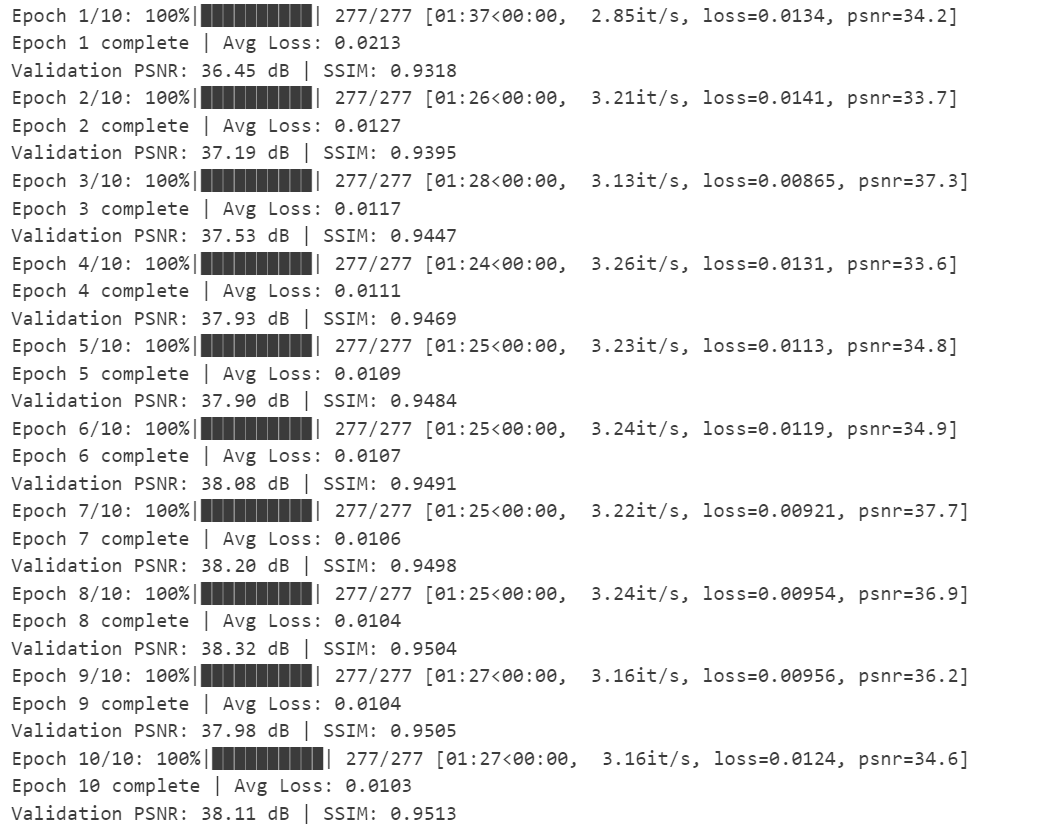

In [12]:
# Path to save the full checkpoint
save_path = "/kaggle/working/rcan_final_checkpoint.pth"

# Prepare checkpoint dictionary
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_psnrs': val_psnrs,
    'val_ssims': val_ssims,
    'epoch': epochs
}

# Save checkpoint
torch.save(checkpoint, save_path)

print(f"Model and optimizer saved to {save_path}")


Model and optimizer saved to /kaggle/working/rcan_final_checkpoint.pth


In [13]:
# # Save the model
save_path = "/kaggle/working/rcan_model.pth"
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")


Model saved to /kaggle/working/rcan_model.pth


In [ ]:
import os
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage
import torch
from glob import glob
from tqdm import tqdm


# RCAN Model Definition 
class RCAB(nn.Module):
    def __init__(self, channels):
        super(RCAB, self).__init__()
        self.body = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(channels, channels, 3, padding=1)
        )
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // 8, 1),
            nn.ReLU(),
            nn.Conv2d(channels // 8, channels, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        res = self.body(x)
        ca = self.channel_attention(res)
        return x + res * ca

class RCAN(nn.Module):
    def __init__(self, num_blocks=10):
        super(RCAN, self).__init__()
        self.head = nn.Conv2d(3, 64, 3, padding=1)
        self.body = nn.Sequential(*[RCAB(64) for _ in range(num_blocks)])
        self.upsample = nn.Sequential(
            nn.Conv2d(64, 256, 3, padding=1),
            nn.PixelShuffle(2),
            nn.ReLU(),
            nn.Conv2d(64, 256, 3, padding=1),
            nn.PixelShuffle(2),
            nn.ReLU()
        )
        self.tail = nn.Conv2d(64, 3, 3, padding=1)

    def forward(self, x):
        x = self.head(x)
        res = self.body(x)
        x = x + res
        x = self.upsample(x)
        x = self.tail(x)
        return x

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_dir = "/kaggle/input/dlp-jan-2025-nppe-3/archive/test"
output_dir = "/kaggle/working/predicted_images"
os.makedirs(output_dir, exist_ok=True)

# Load Model
model = RCAN().to(device)
model.load_state_dict(torch.load("/kaggle/working/rcan_model.pth", map_location=device))
model.eval()

# Predict and Save
transform = ToTensor()
to_pil = ToPILImage()
test_files = sorted(glob(os.path.join(test_dir, "*")))

with torch.no_grad():
    for path in tqdm(test_files, desc="Predicting"):
        img = Image.open(path).convert("RGB")
        img_tensor = transform(img).unsqueeze(0).to(device)

        output = model(img_tensor)
        output = output.squeeze(0).clamp(0, 1).cpu()

        output_img = to_pil(output)
        filename = os.path.basename(path)
        output_img.save(os.path.join(output_dir, filename))

print("✅ All test images predicted and saved.")


<ipython-input-14-3dd9548636c7>:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/rcan_model.pth", map_location=device))
Pr

✅ All test images predicted and saved.


In [16]:
import os
import numpy as np
import pandas as pd
from PIL import Image

def images_to_csv(folder_path, output_csv):
    data_rows = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path).convert('L') 
            image_array = np.array(image).flatten()[::8]
            # Replace 'test_' with 'gt_' in the ID
            image_id = filename.split('.')[0].replace('test_', 'gt_')
            data_rows.append([image_id, *image_array])
    column_names = ['ID'] + [f'pixel_{i}' for i in range(len(data_rows[0]) - 1)]
    df = pd.DataFrame(data_rows, columns=column_names)
    df.to_csv(output_csv, index=False)
    print(f'Successfully saved to {output_csv}')

folder_path = '/kaggle/working/predicted_images'
output_csv = '/kaggle/working/submission.csv'
images_to_csv(folder_path, output_csv)

Successfully saved to /kaggle/working/submission.csv


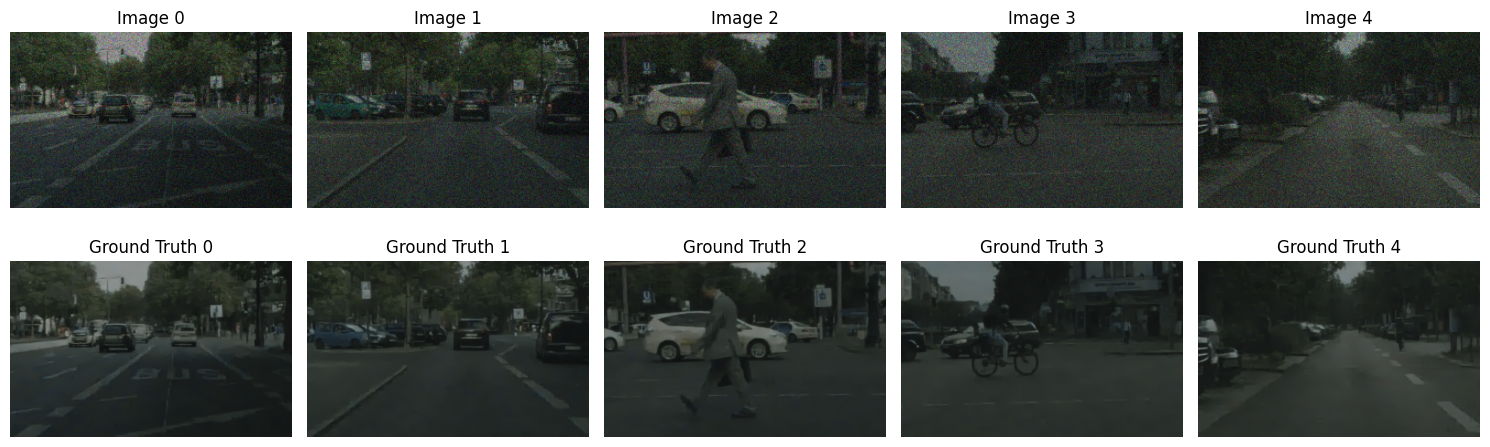

In [17]:
display_images_in_range(test_images, "/kaggle/working/predicted_images", start_index=0, end_index=5)

In [27]:
torch.cuda.empty_cache()